<div>
    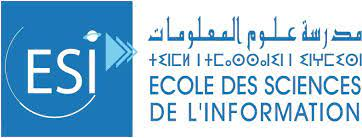
</div>

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;">
<p style="color:orange;font-weight:bold"><u>Réalisé par:</u></p>
<ul >
    <li>ELGHAZI Soufiane</li>
    <li>MAASRI Amine</li>
    <li>Dahmou Youssef</li>
    <li>OUAHIB Yassine</li>
</ul>
    
</div>

<h1 style='color:purple' align='center'>Projet Text mining: News SUM </h1>

<h2 style='color:olive' align='center'>PEGASUSE </h2>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;">
<p style="color:purple;">Étape 2 : Création et évaluation des modèles : PEGASUSE</p><br>
<p style="color:purple;">Références</p>
 Les liens vers les ressources utilisées et consulté .<br><br>
</div>

<h2 style='color:purple'>Importation des Bibliothèques: </h2>

In [3]:
!pip install torch
!pip install transformers

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
import torch

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
1. Chargement des Données:
</div>

In [11]:
df = pd.read_excel('../Data/Final_Data/corpus.xlsx')
df.columns = ['Summary','Content'] #.iloc[:100]
df

,Summary,Content
0,it s heartbreaking. initial surveys indicated...,severe storms and at least one tornado slammed...
1,by the time the tornado siren sounded one week...,by the time the tornado siren sounded one week...
2,it s heartbreaking. initial surveys indicated...,severe storms and at least one tornado slammed...
3,the storm dumped 4 inches of rain over much of...,a powerful storm that s been slamming the nort...
4,how relevant is this ad to you video player wa...,1 how relevant is this ad to you video player ...
...,...,...
1888,lucy copland 27 from lincolnshire was worried ...,by kelly strange published 08:10 est 29 may 20...
1889,english heritage bestow grade ii listing on im...,by harriet arkell wartime bunker used by winst...
1890,the nobel prize was awarded to carlos saavedra...,by sam creighton nobel peace prize has sold fo...
1891,bronwyn calver was cycling when kangaroo leape...,a cyclist has suffered freak accident after be...


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
2. Division des Données :
</div>

In [13]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Tokenisation avec PEGASUS :
</div>

In [14]:
# Initialize the PEGASUS tokenizer
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-large')

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

> ### - Tokenise les données d'entraînement et de validation pour le contenu et les résumés.

In [15]:
# Tokenize the training data
train_content = list(train_df['Content'])
train_summary = list(train_df['Summary'])

# Ensure the content is in string format
train_content = [str(content) for content in train_content]

train_data = tokenizer(
    train_content,
    truncation=True,
    padding=True,
    max_length=1000,
    return_tensors='pt',
    verbose=True
)

train_summary_data = tokenizer(
    train_summary,
    truncation=True,
    padding=True,
    max_length=200,  # Adjust the max_length as needed for summaries
    return_tensors='pt',
    verbose=True
)

In [16]:
# Tokenize the validation data
val_content = list(val_df['Content'])
val_summary = list(val_df['Summary'])

# Ensure the content is in string format
val_content = [str(content) for content in val_content]

val_data = tokenizer(
    val_content,
    truncation=True,
    padding=True,
    max_length=1000,
    return_tensors='pt',
    verbose=True
)

val_summary_data = tokenizer(
    val_summary,
    truncation=True,
    padding=True,
    max_length=200,  # Adjust the max_length as needed for summaries
    return_tensors='pt',
    verbose=True
)

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
3. Classe de Dataset Personnalisée :
</div>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Définit une classe de dataset personnalisée pour gérer les données tokenisées et les labels.
</div>

In [17]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # Assuming 'labels' is the key for summary input_ids
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
4. Création d'Instances de Dataset :
</div>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Création des instances du dataset personnalisé pour les ensembles d'entraînement et de validation
</div>

In [ ]:
# Create CustomDataset instances for both training and validation
train_dataset = CustomDataset(train_data, train_summary_data)
val_dataset = CustomDataset(val_data, val_summary_data)

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
5. Data Loaders :
</div>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Création des instances DataLoader pour le chargement efficace des lots pendant l'entraînement et la validation.
</div>

In [ ]:
# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
6. Initialisation du Modèle :
</div>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Initialise le modèle PEGASUS pour la génération conditionnelle.
</div>

In [ ]:
model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-large')

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
7. Configuration de l'Entraînement :
</div>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Configuration des paramètres d'entraînement tels que le répertoire de sortie, la taille du lot, le nombre d'époques, etc.
</div>

In [18]:
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    save_steps=10_000,
    save_total_limit=2,
)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
8.  Initialisation du Trainer :
</div>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Initialise le Trainer avec le modèle, les arguments d'entraînement et les datasets</div>

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
7.Modèle et Données sur le GPU :
</div>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Vérification de la disponibilité du GPU et déplace le modèle sur le GPU s'il est disponible.</div>

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model and data to the GPU
model.to(device)

PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(1024, 1024)
      (layers): ModuleList(
        (0-15): 16 x PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_no

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
 8.Entraînement :
</div>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Lancement le processus d'entraînement et stocke l'historique de l'entraînement dans la variable history.</div>

In [19]:
history =  trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/tmp/ipykernel_42/21769689.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_42/21769689.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # Assuming 'labels' is the key for summary input_ids


Step,Training Loss
500,3.673700
1000,0.541400
1500,0.508500
2000,0.455100
2500,0.460000
3000,0.398600
3500,0.412900
4000,0.380600
4500,0.376300


/tmp/ipykernel_42/21769689.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_42/21769689.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # Assuming 'labels' is the key for summary input_ids


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
9.Sauvegarde du Modèle Fine-Tuné :
</div>

In [20]:
# Save the fine-tuned model
model.save_pretrained('/kaggle/working/models/fine_tuned_pegasus1')

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
10. Évaluation du Modèle sur l'Ensemble de Validation :
</div>

In [61]:
# Evaluate the model on the validation dataset
results = trainer.evaluate()
results

/tmp/ipykernel_42/21769689.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_42/21769689.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # Assuming 'labels' is the key for summary input_ids


{'eval_loss': 0.42184802889823914,
 'eval_runtime': 53.1444,
 'eval_samples_per_second': 7.132,
 'eval_steps_per_second': 7.132,
 'epoch': 3.0}

In [33]:
data = pd.read_csv('/kaggle/input/news-summarization/data.csv')

In [54]:
dt= data.iloc[:30]
references = list(dt.Summary)
contents = list(dt.Content)

In [55]:
predictions = []
for cntnt in contents :
    predictions.append(Summarizer(cntnt[:1000]))
predictions

['New York police are concerned drones could become tools for terrorists, and are investigating ways to stop potential attacks.',
 'Perhaps Australian porn star Angela White thought she was bringing the ultimate steamy study fantasy to life when she and a partner secretly filmed sex acts in the library of La Trobe University in Melbourne.',
 'For Garcia and Rickie Fowler it made the final few holes of a dramatic third round here in Hoylake all the more torturous.',
 'An Ebola outbreak that began in Guinea four months ago has turned into a cross-border African crisis that could spread to more countries.',
 'Dunedin Deputy Fire Chief Trip Barrs said the hole appeared to be about 12-feet wide when officials arrived on the scene around 6am, but grew to 40-feet-wide and 30-feet-deep by 9am.',
 'The attack this week should have also sent a clear message to both leaderships that if they will not take measures to calm the situation down, further escalation and worse violence is around the corn

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
11 .Calcul des Scores BLEU et ROUGE :
</div>

In [45]:
from nltk.translate import bleu_score
from rouge_score import rouge_scorer

bleu_score = bleu_score.corpus_bleu(references, predictions)
print("BLEU Score:", bleu_score)


BLEU Score: 0.5635279113885795


> ### - Calcule les scores ROUGE entre les prédictions et les références, puis affiche la moyenne des scores F1.

In [60]:
from transformers import PegasusTokenizer
from rouge_score import rouge_scorer


# Initialize the PEGASUS tokenizer
tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-large')
references_ids = tokenizer(references, return_tensors='pt', truncation=True, padding=True)['input_ids']
predictions_ids = tokenizer(predictions, return_tensors='pt', truncation=True, padding=True)['input_ids']
references_text = tokenizer.batch_decode(references_ids, skip_special_tokens=True)
predictions_text = tokenizer.batch_decode(predictions_ids, skip_special_tokens=True)
rouge_scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [rouge_scorer.score(prediction, reference) for prediction, reference in zip(predictions_text, references_text)]
rouge_f1_scores = [score['rougeL'].fmeasure for score in rouge_scores]
average_rouge_f1 = sum(rouge_f1_scores) / len(rouge_f1_scores)
print("Average ROUGE-L F1 Score:", average_rouge_f1)


Average ROUGE-L F1 Score: 0.1953681068059598


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
12. Génération de Résumés avec le Modèle Fine-Tuné :
</div>

In [21]:
# Load the fine-tuned model
fine_tuned_model = PegasusForConditionalGeneration.from_pretrained('/kaggle/working/models/fine_tuned_pegasus1')

In [40]:
# Example: Generate summaries using the fine-tuned model
input_text = """By . Emma Innes . A cystic fibrosis patient has married his girlfriend after having a successful lung transplant. Dane Pollard, 34, was diagnosed with the condition when he was 18 months old and feared he would not survive. The condition caused his lungs to fill with mucus, meaning he needed daily physiotherapy in order to lead a normal life. Dane Pollard met and married his partner, Emma, after his life was saved by a last minute lung transplant . Mr Pollard was diagnosed with cystic fibrosis when he was 18 months old and his health slowly deteriorated . However, his health worsened and he found himself needing a wheelchair and additional oxygen. He eventually ended up housebound and was put on the lung transplant list. In 2008, he received a call to say that some new lungs had been found for him and the operation could go ahead. He believes that if the lungs had not become available, he would not have survived for many more days."""

def Summarizer(input_text):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids

    # Generate the summary
    summary_ids = fine_tuned_model.generate(input_ids)

    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary
Summarizer(input_text)

'Dane Pollard met and married his partner Emma after his life was saved by a last minute lung transplant. Dane Pollard met and married his partner, Emma, after his life was saved by a last minute lung transplant.'

In [26]:
results

{'eval_loss': 0.42184802889823914,
 'eval_runtime': 53.3019,
 'eval_samples_per_second': 7.11,
 'eval_steps_per_second': 7.11,
 'epoch': 3.0}

In [57]:
pred = predictions

---
<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
<ul>
<li><a href="https://blog.research.google/2016/08/text-summarization-with-tensorflow.html" style="color:white;"> Ressource 1</a></li>
<li><a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" style="color:white;"> Ressource 2</a></li>
<li><a href="https://www.kaggle.com/datasets/sbhatti/news-summarization/data" style="color:white;"> Ressource 3 </a></li>
<li><a href="https://radimrehurek.com/gensim/models/word2vec.html" style="color:white;"> Ressource4 </a></li>
    
</ul>
</div>

---

<h2 style='color:olive' align='center'>END </h2>